In [1]:
%cd "~/Projects/Segmentation/TreeSeg"
import json
import math
import os
from pathlib import Path

import json
import hashlib
import matplotlib.pyplot as plt
import networkx as nx
import nvdiffrast.torch as dr
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import yaml
from rich.console import Console
from rich.tree import Tree
import torch_geometric as pyg

import tree_segmentation as ts
import tree_segmentation.extension as ext
from tree_segmentation.extension import ops_3d, Mesh, utils
from semantic_sam import SemanticSAM, semantic_sam_l
from tree_segmentation import Tree3Dv2, Tree3D, TreePredictor, TreeSegmentMetric, Tree2D
from tree_segmentation.util import show_masks, show_all_levels, get_hash_name, color_mask
from evaluation.eval_PartNet import get_mesh_and_gt_tree, get_images, get_shapes, load_images
from tree_segmentation.render import render_mesh
from paper.paper_util import save_3d_part_meshs, save_3d_view
import matplotlib.image as mpimg
import networkx as nx
import cv2


/home/wan/Projects/Segmentation/TreeSeg
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2023-08-10 20:54:18.039073: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 20:54:22.757561: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/wan/miniconda3/envs/wan/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:
2023-08-10 20:54:22.757870: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so

In [2]:
print(torch.__version__)
%load_ext autoreload
%autoreload 2
%matplotlib inline

2.0.1+cu117


In [3]:
torch.set_grad_enabled(False)
console = Console()
device = torch.device("cuda")
# device = torch.device("cpu")
utils.set_printoptions(linewidth=120)
glctx = dr.RasterizeCudaContext()

In [4]:
data_root = Path('~/data/PartNet/data_v0').expanduser()
# cache_root = Path('~/wan_code/segmentation/tree_segmentation/results').expanduser()
print(f"Data Root: {data_root}")
image_dir = data_root.parent.joinpath('tree_seg')


save_root = Path('/data5/wan/PartNet/').expanduser()
categories = os.listdir(save_root)
print(f"Save Root:", save_root)
print(f"Categories: {len(categories)}")
results = {}
for cat in categories:
    results [cat]= list(save_root.joinpath(cat).glob("*/my.tree3dv2"))
    print(f'Cat: {cat} have {len(results[cat])} results')

Data Root: /home/wan/data/PartNet/data_v0
Save Root: /data5/wan/PartNet
Categories: 8
Cat: Faucet have 28 results
Cat: Clock have 27 results
Cat: Dishwasher have 18 results
Cat: Chair have 29 results
Cat: Bed have 20 results
Cat: Earphone have 29 results
Cat: Table have 15 results
Cat: Lamp have 28 results


In [5]:
index = 0
cat = categories[0]
print('Now Category:', cat)
best = -1
best_mesh = 0
for result_path in results[cat]: # type: Path
    print(result_path)
    mesh = torch.load(result_path.with_name(f'{result_path.parts[-2]}.mesh_cache'))
    print(mesh)
    gt = Tree3Dv2(mesh, device=device)
    gt.load(result_path.with_name('gt.tree3dv2'))

    prediction = Tree3Dv2(mesh, device=device)
    prediction.load(result_path)

    metric = TreeSegmentMetric()
    metric.update(prediction, gt)
    if metric.mTQ > best:
        best = metric.mTQ
        best_mesh = result_path
print('best mesh:', best_mesh, 'best score:', best)

Now Category: Faucet
/data5/wan/PartNet/Faucet/1719/my.tree3dv2
Mesh(vertices=3717, faces=13046)
[Tree3D] load results from: /data5/wan/PartNet/Faucet/1719/gt.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet/Faucet/1719/my.tree3dv2
/data5/wan/PartNet/Faucet/1787/my.tree3dv2
Mesh(vertices=51608, faces=35100)
[Tree3D] load results from: /data5/wan/PartNet/Faucet/1787/gt.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet/Faucet/1787/my.tree3dv2
/data5/wan/PartNet/Faucet/1715/my.tree3dv2
Mesh(vertices=60702, faces=18460)
[Tree3D] load results from: /data5/wan/PartNet/Faucet/1715/gt.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet/Faucet/1715/my.tree3dv2
/data5/wan/PartNet/Faucet/1946/my.tree3dv2
Mesh(vertices=40305, faces=29928)
[Tree3D] load results from: /data5/wan/PartNet/Faucet/1946/gt.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet/Faucet/1946/my.tree3dv2
/data5/wan/PartNet/Faucet/1859/my.tree3dv2
Mesh(vertices=148730, faces=78530)
[Tree3D] load results from

Mesh(vertices=166798, faces=79755)
[Tree3D] load results from: /data5/wan/PartNet/Faucet/1933/gt.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet/Faucet/1933/my.tree3dv2
torch.Size([100, 1024, 1024])


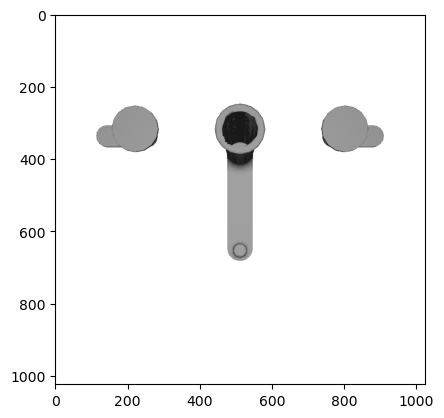

In [6]:
mesh = torch.load(best_mesh.with_name(f'{best_mesh.parts[-2]}.mesh_cache'))
print(mesh)
gt = Tree3Dv2(mesh, device=device)
gt.load(best_mesh.with_name('gt.tree3dv2'))

prediction = Tree3Dv2(mesh, device=device)
prediction.load(best_mesh)

images, tri_ids, Tw2v = load_images(mesh, image_dir.joinpath(cat, best_mesh.parent.name), num_views=100, colored=False)
plt.imshow(images[0].cpu().numpy())
print(tri_ids.shape)

0: Tree Root
├── 1
├── 2
├── 3
│   ├── 7
│   └── 8
├── 4
│   ├── 9
│   └── 10
├── 5
│   ├── 11
│   └── 12
└── 6
    ├── 13
    └── 14

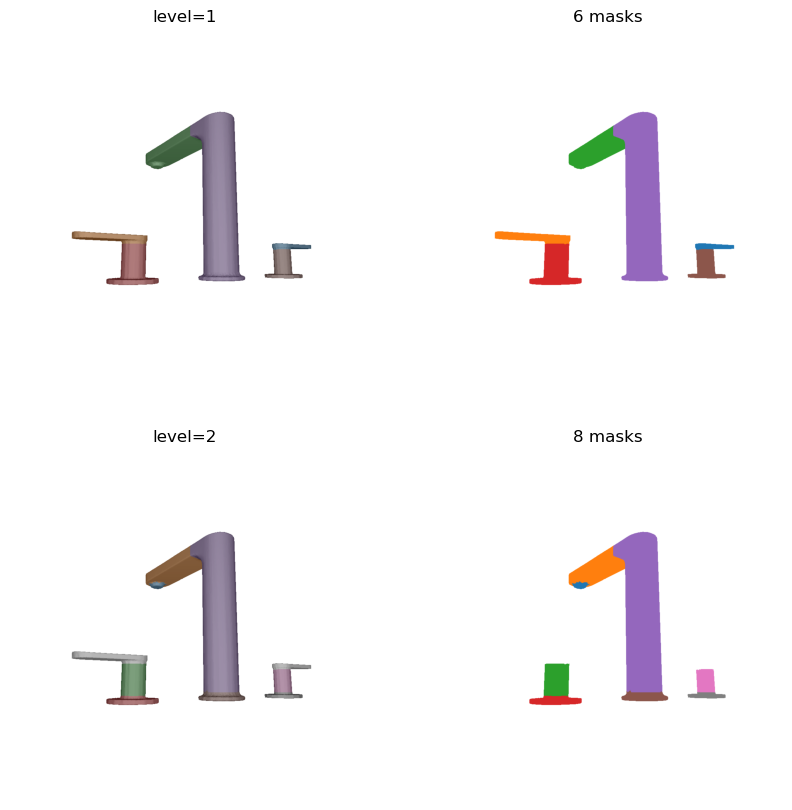

In [7]:
show_index = 40
show_all_levels(images[show_index,], gt, tri_ids[show_index])
gt.print_tree()

In [8]:
save_dir = Path(f'./results/PartNet_{cat}_gt/view{show_index}')
save_dir.mkdir(exist_ok=True, parents=True)
save_3d_view(save_dir, gt, images[show_index], tri_ids[show_index])
save_3d_part_meshs(save_dir.parent, gt, mesh)

Saved 2d level 1 with nodes: [1]
Saved 2d level 2 with nodes: [2, 3, 4, 5, 6, 7]
Saved 2d level 3 with nodes: [8, 9, 10, 11, 12, 13]
There are 13 masks in the view of tree3d 
Saved level 1 with nodes: [1, 2, 3, 4, 5, 6]
Saved level 2 with nodes: [7, 8, 9, 10, 11, 12, 13, 14]


0: Tree Root
└── 17
    ├── 8
    │   ├── 10
    │   │   ├── 15
    │   │   └── 7
    │   └── 2
    ├── 11
    │   └── 1
    │       ├── 18
    │       └── 3
    └── 13
        ├── 22
        ├── 16
        ├── 4
        │   └── 9
        │       └── 20
        └── 5
            └── 12

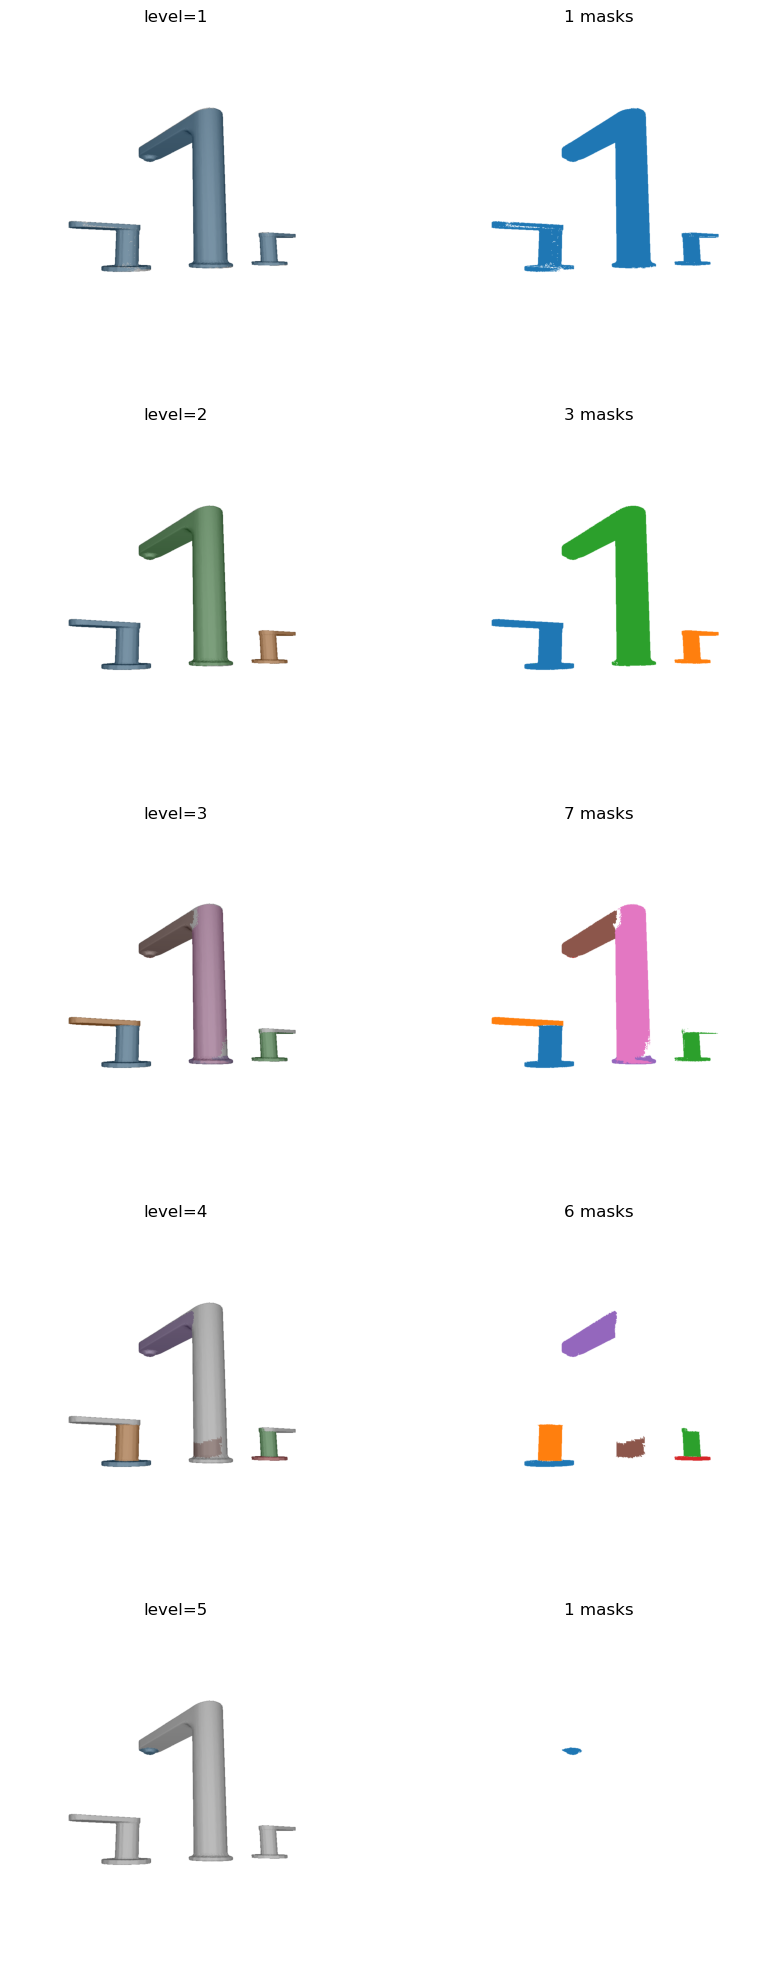

In [9]:
show_index = 40
show_all_levels(images[show_index,], prediction, tri_ids[show_index])
prediction.print_tree()

In [10]:
save_dir = Path(f'./results/PartNet_{cat}/view{show_index}')
save_dir.mkdir(exist_ok=True, parents=True)
save_3d_view(save_dir, gt, images[show_index], tri_ids[show_index])
save_3d_part_meshs(save_dir.parent, gt, mesh)

Saved 2d level 1 with nodes: [1]
Saved 2d level 2 with nodes: [2, 3, 4, 5, 6, 7]
Saved 2d level 3 with nodes: [8, 9, 10, 11, 12, 13]
There are 13 masks in the view of tree3d 
Saved level 1 with nodes: [1, 2, 3, 4, 5, 6]
Saved level 2 with nodes: [7, 8, 9, 10, 11, 12, 13, 14]
